In [1]:
using DifferentialEquations
using LinearAlgebra
using Plots

include("../model/Plant.jl")

Main.Plant

In [2]:
p = Plant.Params()
state = Plant.State()
u0 = [state.x, state.y, state.n, state.h, state.Ca, state.V, state.Isyn]
tspan = (0, 1e6)
prob = ODEProblem(Plant.melibeNew!, u0, tspan, p)
sol = solve(prob);

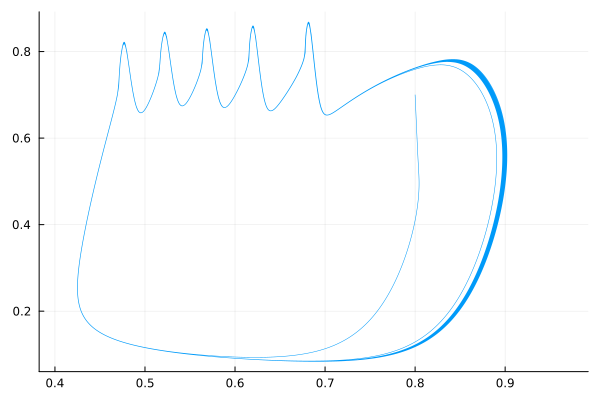

In [3]:
plot(sol, idxs=(5, 1), lw=0.5, legend=false, dpi=1000)

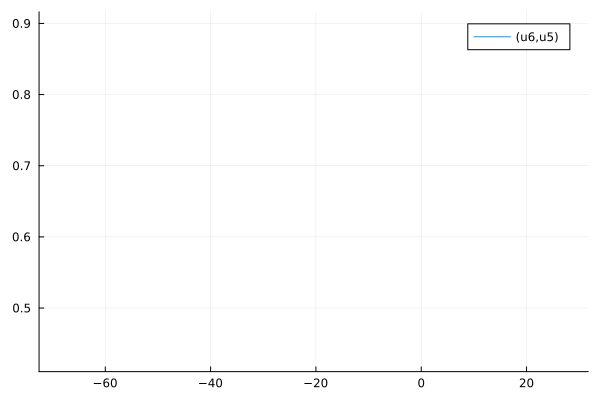

In [4]:
plot(sol, idxs=(6, 5), lw=3e-2)

In [3]:
function countSpikes(sol)
    x_threshold = 0.5 # Clearly the correct threshold is actually obtained by counting the winding number about the equilibrium.

    # Obtain burst reset times.
    resets = []
    for i in 2:length(sol)
        if sol[i-1][1] < x_threshold < sol[i][1]
            push!(resets, i)
        end
    end

    #print("$(length(resets)) burst resets observed.")

    V_threshold = 0.0

    # Obtain spike counts per burst.
    spike_counts = []
    for i in 1:length(resets)-1
        spike_count = 0
        for j in resets[i]:resets[i+1]
            if sol[j-1][6] < V_threshold < sol[j][6]
                spike_count += 1
            end
        end
        push!(spike_counts, spike_count)
    end

    return spike_counts
end

countSpikes (generic function with 1 method)

In [4]:
function transitionMap(spike_counts)
    plt = scatter(1, markeralpha=0.2, legend=false)
    for i in 1:length(spike_counts)-1
        push!(plt, (spike_counts[i], spike_counts[i+1]))
    end
    return plt
end

transitionMap (generic function with 1 method)

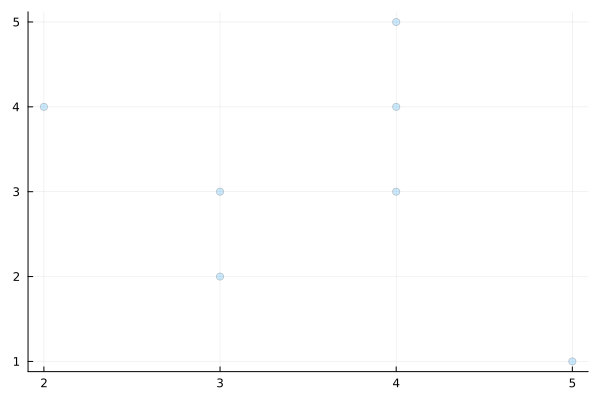

In [23]:
p = Plant.Params(
    Δx = -2.0
)

transitionMap(countSpikes(p, state))

In [5]:
function markovChain(spike_counts)
    if length(spike_counts) == 0
        return zeros(0, 0)
    end
    size = max(spike_counts...)
    if size == 0
        return zeros(0, 0)
    end
    rows = []
    for i in 0:size
        row = zeros(size+1)
        for j in 1:length(spike_counts)-1
            if spike_counts[j] == i
                row[spike_counts[j+1]+1] += 1
            end
        end
        if sum(row) == 0
            push!(rows, row)
        else
            push!(rows, row/sum(row))
        end
    end
    return reduce(vcat, transpose.(rows))
end

markovChain (generic function with 1 method)

In [6]:
ΔCa_length = 600
Δx_length = 300

range_ΔCa = range(22.0, 26.5, length=ΔCa_length)
range_Δx = range(-2.7, -2.475, length=Δx_length)

-2.7:0.0007525083612040134:-2.475

In [7]:
function melibeNewHelper!(du, u, p, t)
    θ = Plant.Params(
        Cₘ   = p[1],
        gI   = p[2],
        gK   = p[3],
        gₕ   = p[4],
        gL   = p[5],
        gT   = p[6],
        gKCa = p[7],
        EI   = p[8],
        EK   = p[9],
        Eₕ   = p[10],
        EL   = p[11],
        ECa  = p[12],
        Kc   = p[13],
        τₓ   = p[14],
        ρ    = p[15],
        Δx   = p[16],
        ΔCa  = p[17]
    )
    Plant.melibeNew!(du, u, θ, t)
end

melibeNewHelper! (generic function with 1 method)

In [8]:
ΔCa_length = 25
Δx_length = 25

range_ΔCa = range(22.0, 26.5, length=ΔCa_length)
range_Δx = range(-2.7, -2.475, length=Δx_length)
params = []
for ΔCa in range_ΔCa
    for Δx in range_Δx
        θ = Plant.Params(
            ΔCa = ΔCa,
            Δx = Δx
        )
        p = [
            θ.Cₘ,
            θ.gI,
            θ.gK,
            θ.gₕ,
            θ.gL,
            θ.gT,
            θ.gKCa,
            θ.EI,
            θ.EK,
            θ.Eₕ,
            θ.EL,
            θ.ECa,
            θ.Kc,
            θ.τₓ,
            θ.ρ,
            θ.Δx,
            θ.ΔCa
        ]
        push!(params, p)
    end
end

tspan = (0, 1e5)

(0, 100000.0)

In [23]:
prob = ODEProblem(melibeNewHelper!, u0, tspan, params[1])
prob_func(prob, i, repeat) = remake(prob, p=params[trunc(Int, i)]) # Why are we getting Floats here?
monteprob = EnsembleProblem(prob, prob_func=prob_func, safetycopy=false)
sol = solve(monteprob, Tsit5(), EnsembleThreads(), trajectories=ΔCa_length*Δx_length, verbose=false);

In [24]:
complexities = zeros(Δx_length, ΔCa_length)

for ΔCa in 1:ΔCa_length
    for Δx in 1:Δx_length
        complexities[Δx, ΔCa] = tr(markovChain(countSpikes(sol[(ΔCa-1)*Δx_length + Δx])))
    end
end

heatmap(complexities, xlabel="\$Δ_{Ca}\$", ylabel="\$Δ_x\$", color=:ice)

: 

: 

In [18]:
testmat = zeros(10, 10)
testmat[3, 2] = 1.0
testmat

10×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0